In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from yelpapi import YelpAPI
from pprint import pprint
from config import api_key

In [3]:
yelp_api = YelpAPI(api_key)
#print(yelp_api)

In [4]:
#pulling YELP data for encinitas specific to similar categories
#this should help answer the question on what city based on competition 
cities = ["Encinitas","Oceanside","Carlsbad"]
for ct in cities:
    search_results = yelp_api.search_query(location=ct,
                                           term='restaurants',
                                           categories='japanese,asian,fusion,sushi,hibachi',limit=50
                                           )                                          
print(json.dumps(search_results, indent=4))

{
    "businesses": [
        {
            "id": "1vdHkdvH-tJUdMc01M2cvQ",
            "alias": "the-land-and-water-co-carlsbad",
            "name": "The Land & Water Co",
            "image_url": "https://s3-media3.fl.yelpcdn.com/bphoto/5_NVfdeImjfo54fbGKZjFA/o.jpg",
            "is_closed": false,
            "url": "https://www.yelp.com/biz/the-land-and-water-co-carlsbad?adjust_creative=M5QLGhAlzFV-ZvKGpjS6IQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=M5QLGhAlzFV-ZvKGpjS6IQ",
            "review_count": 713,
            "categories": [
                {
                    "alias": "sushi",
                    "title": "Sushi Bars"
                },
                {
                    "alias": "tapasmallplates",
                    "title": "Tapas/Small Plates"
                },
                {
                    "alias": "newamerican",
                    "title": "American (New)"
                }
            ],
            "rating": 4.0,
      

In [5]:
#lists
categories=[]
rating=[]
price=[]
review_count=[]
location=[]

In [6]:
restaurant = search_results['businesses']
for rest in restaurant:
    
    try:
        price.append(rest['price'])
        rating.append(rest['rating'])
        review_count.append(rest['review_count'])
        location.append(rest['location']['city'])
        categories.append(rest['categories'][0]['title'])
    except KeyError:
        price.append(np.nan)
        rating.append(np.nan)
        review_count.append(np.nan)
        location.append(np.nan)
        categories.append(np.nan)

In [7]:
city_count = len(cities)
city_count

3

In [8]:
#checking to see how many was pulled in the JSON file
len(restaurant)

50

In [9]:
#checking to see the length of each array to create the df. 
print(len(rating))
print(len(price))
print(len(review_count))
print(len(location))
print(len(categories))

50
50
50
50
50


In [10]:
#creating the df for Encinitas specifically 
restaurant_df = pd.DataFrame({"City":location,
                              "Category":categories,
                              "Price Range":price,
                              "Rating":rating,
                              "Review Count":review_count
                             })
restaurant_df = restaurant_df.dropna(how='any')
restaurant_df.head()

,City,Category,Price Range,Rating,Review Count
0,Carlsbad,Sushi Bars,$$,4.0,713.0
1,Carlsbad,Ramen,$$,3.5,287.0
2,Carlsbad,Asian Fusion,$$,4.0,901.0
3,Carlsbad,Japanese,$,4.5,726.0
4,Carlsbad,Sushi Bars,$$,4.5,935.0


In [11]:
#cleaning up the df- the data was pulling other cities that are not Enc.
restaurant_df = restaurant_df.set_index("City")
restaurant_df.head()

,Category,Price Range,Rating,Review Count
City,,,,
Carlsbad,Sushi Bars,$$,4.0,713.0
Carlsbad,Ramen,$$,3.5,287.0
Carlsbad,Asian Fusion,$$,4.0,901.0
Carlsbad,Japanese,$,4.5,726.0
Carlsbad,Sushi Bars,$$,4.5,935.0


In [12]:
restaurant_df= restaurant_df.drop(['Vista', 'San Marcos', 'San Diego', 'Solana Beach'])
restaurant_df.head()

,Category,Price Range,Rating,Review Count
City,,,,
Carlsbad,Sushi Bars,$$,4.0,713.0
Carlsbad,Ramen,$$,3.5,287.0
Carlsbad,Asian Fusion,$$,4.0,901.0
Carlsbad,Japanese,$,4.5,726.0
Carlsbad,Sushi Bars,$$,4.5,935.0


In [13]:
restaurant_df= restaurant_df.reset_index()
restaurant_df.head()

,City,Category,Price Range,Rating,Review Count
0,Carlsbad,Sushi Bars,$$,4.0,713.0
1,Carlsbad,Ramen,$$,3.5,287.0
2,Carlsbad,Asian Fusion,$$,4.0,901.0
3,Carlsbad,Japanese,$,4.5,726.0
4,Carlsbad,Sushi Bars,$$,4.5,935.0


In [14]:
encinitas_df = restaurant_df.loc[restaurant_df["City"]=="Encinitas",:]
encinitas_rating = encinitas_df.groupby("Category").mean()["Rating"].rename("Ave. Rating Encinitas")
encinitas_rating = pd.DataFrame(encinitas_rating)
encinitas_rating["Ave. Rev Count Enc"] = encinitas_df.groupby("Category").mean()["Review Count"]
encinitas_rating = encinitas_rating.reset_index(level=None, drop =False)
encinitas_rating

,Category,Ave. Rating Encinitas,Ave. Rev Count Enc
0,Asian Fusion,4.000000,486.0
1,Japanese,4.500000,395.0
2,Ramen,4.500000,43.0
3,Sushi Bars,3.916667,308.0


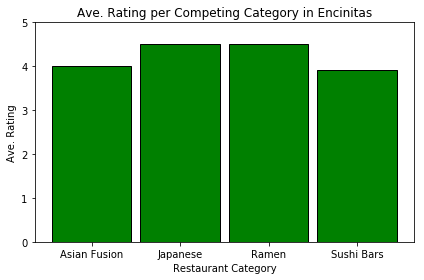

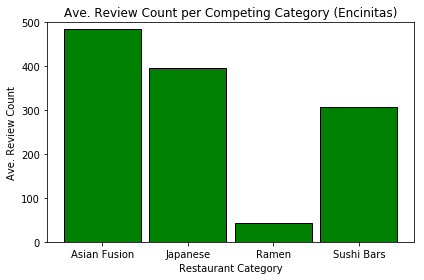

In [24]:
#plotting encinitas data fig 1
fig, ax1 = plt.subplots()
category = encinitas_rating["Category"]
x_axis = np.arange(len(category))
y = encinitas_rating["Ave. Rating Encinitas"]
y_2= encinitas_rating["Ave. Rev Count Enc"]
ticks = [value for value in x_axis]
ax1.bar(category, y, width=.9,color='green',ec='black')
plt.title("Ave. Rating per Competing Category in Encinitas")
plt.ylabel("Ave. Rating")
plt.xticks(ticks, category)
plt.xlabel("Restaurant Category")
plt.ylim(0, 5)
plt.tight_layout()
plt.savefig("figures/ Ave. Rating Encinitas.png")
plt.show()

#figure 2
fig2, ax2= plt.subplots()
ax2.bar(category, y_2, width=.9, color='green',ec='black')
plt.title("Ave. Review Count per Competing Category (Encinitas)")
plt.ylabel("Ave. Review Count")
plt.xticks(ticks, category)
plt.xlabel("Restaurant Category")
plt.ylim(0, 500)
plt.tight_layout()
plt.savefig("figures/ Ave. Rev Count Encinitas.png")
plt.show()




In [16]:
#pull Carlsbad data
carlsbad_df = restaurant_df.loc[restaurant_df["City"]=="Carlsbad",:]
carlsbad_rating = carlsbad_df.groupby("Category").mean()["Rating"].rename("Ave. Rating Carlsbad")
carlsbad_rating = pd.DataFrame(carlsbad_rating)
carlsbad_rating["Ave. Rev Count Carlsbad"] = carlsbad_df.groupby("Category").mean()["Review Count"]
carlsbad_rating = carlsbad_rating.reset_index(level=None, drop =False)
carlsbad_rating

,Category,Ave. Rating Carlsbad,Ave. Rev Count Carlsbad
0,Asian Fusion,4.0000,901.000
1,Japanese,4.0000,300.200
2,Ramen,3.0000,183.000
3,Sushi Bars,3.8125,474.375


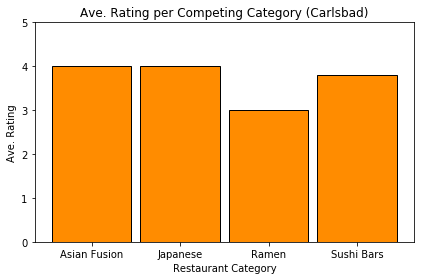

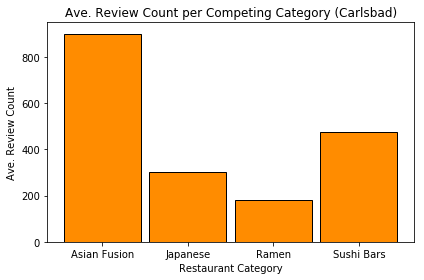

In [25]:
#plotting encinitas data fig 1
fig3, ax3 = plt.subplots()
category = carlsbad_rating["Category"]
x_axis = np.arange(len(category))
y = carlsbad_rating["Ave. Rating Carlsbad"]
y_2= carlsbad_rating["Ave. Rev Count Carlsbad"]
ticks = [value for value in x_axis]
ax3.bar(category, y, width=.9,color='darkorange',ec='black')
plt.title("Ave. Rating per Competing Category (Carlsbad)")
plt.ylabel("Ave. Rating")
plt.xticks(ticks, category)
plt.xlabel("Restaurant Category")
plt.ylim(0, 5)
plt.tight_layout()
plt.savefig("figures/ Ave. Rating Carlsbad.png")
plt.show()

#figure 2
fig4, ax4= plt.subplots()
ax4.bar(category, y_2, width=.9, color='darkorange', ec='black')
plt.title("Ave. Review Count per Competing Category (Carlsbad)")
plt.ylabel("Ave. Review Count")
plt.xticks(ticks, category)
plt.xlabel("Restaurant Category")
plt.ylim(0, 950)
plt.tight_layout()
plt.savefig("figures/ Ave. Rev Count Carlsbad.png")
plt.show()

In [18]:
#pull Oceanside data
oceanside_df = restaurant_df.loc[restaurant_df["City"]=="Oceanside",:]
oceanside_rating = oceanside_df.groupby("Category").mean()["Rating"].rename("Ave. Rating Oceanside")
oceanside_rating = pd.DataFrame(oceanside_rating)
oceanside_rating = oceanside_rating.drop(['American (New)'])
oceanside_rating["Ave. Rev Count Oceanside"] = oceanside_df.groupby("Category").mean()["Review Count"]
oceanside_rating = oceanside_rating.reset_index(level=None, drop =False)
oceanside_rating

,Category,Ave. Rating Oceanside,Ave. Rev Count Oceanside
0,Japanese,4.166667,328.0
1,Ramen,4.000000,427.0
2,Sushi Bars,4.100000,477.0


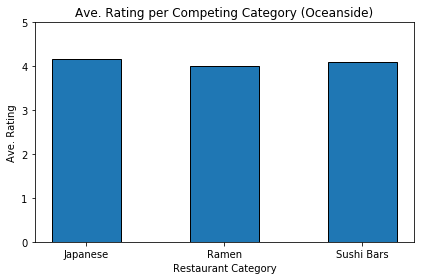

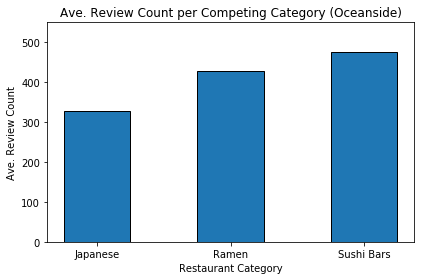

In [26]:
#plotting encinitas data fig 1
fig5, ax5= plt.subplots()
category = oceanside_rating["Category"]
x_axis = np.arange(len(category))
y = oceanside_rating["Ave. Rating Oceanside"]
y_2= oceanside_rating["Ave. Rev Count Oceanside"]
ticks = [value for value in x_axis]
ax5.bar(category, y, width=.5,ec='black')
plt.title("Ave. Rating per Competing Category (Oceanside)")
plt.ylabel("Ave. Rating")
plt.xticks(ticks, category)
plt.xlabel("Restaurant Category")
plt.ylim(0, 5)
plt.tight_layout()
plt.savefig("figures/ Ave. Rating Oceanside.png")
plt.show()

#figure 2
fig6, ax6= plt.subplots()
ax6.bar(category, y_2, width=.5, ec='black')
plt.title("Ave. Review Count per Competing Category (Oceanside)")
plt.ylabel("Ave. Review Count")
plt.xticks(ticks, category)
plt.xlabel("Restaurant Category")
plt.ylim(0, 550)
plt.tight_layout()
plt.savefig("figures/ Ave. Rev Count Oceanside.png")
plt.show()

In [20]:
#dataframe in a differeny view
restaurant_category = restaurant_df.groupby(['City','Category']).mean()['Review Count'].rename("Ave. Review Count")
restaurant_category = pd.DataFrame(restaurant_category)
restaurant_category

Ave. Review Count
City      Category                         
Carlsbad  Asian Fusion              901.000
          Japanese                  300.200
          Ramen                     183.000
          Sushi Bars                474.375
Encinitas Asian Fusion              486.000
          Japanese                  395.000
          Ramen                      43.000
          Sushi Bars                308.000
Oceanside American (New)            722.000
          Japanese                  328.000
          Ramen                     427.000
          Sushi Bars                477.000

In [21]:
restaurant_category["Ave. Rating"] = restaurant_df.groupby(['City','Category']).mean()['Rating']
restaurant_category

Ave. Review Count  Ave. Rating
City      Category                                      
Carlsbad  Asian Fusion              901.000     4.000000
          Japanese                  300.200     4.000000
          Ramen                     183.000     3.000000
          Sushi Bars                474.375     3.812500
Encinitas Asian Fusion              486.000     4.000000
          Japanese                  395.000     4.500000
          Ramen                      43.000     4.500000
          Sushi Bars                308.000     3.916667
Oceanside American (New)            722.000     4.500000
          Japanese                  328.000     4.166667
          Ramen                     427.000     4.000000
          Sushi Bars                477.000     4.100000